# Marginal Value Theorem
A place to test experimental parameters for foraging behavior in line with the marginal value theorem.

## Initial setup

In [1]:
import sys
sys.path.insert(0, '../python')

In [2]:
import numpy as np
from helper import _to_array, cumulative_reward, get_optimal_values
from scipy.optimize import broyden1
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from importlib import reload
import helper
reload(helper)

<module 'helper' from '../python/helper.py'>

## Theory
### Optimal residence time
Let's define a patchy environment as consisting of the following parameters:

$\quad T_{p}^{(i)}$: time spent harvesting reward in patch $i$  
$\quad T_{t}^{(i)}$: time spent traveling to patch $i$  
$\quad R^{(i)}(t^{(i)})$: amount of reward harvested in patch $i$ after time $t^{(i)}$ (i.e. the *gain function*)  
$\quad s$: search cost per unit time

The average reward intake $\bar{E}$ across the environment is:

$
\begin{align}
\quad \bar{E} 
&= \frac{\text{total energy}}{\text{total time}} \\
&= \frac{\sum_{i} \left ( R^{(i)}(T_{p}^{(i)}) - sT_{t}^{(i)} \right )}{\sum_{i} \left ( T_{t}^{(i)} + T_{p}^{(i)} \right )} \\
&= \frac{R^{(i)}(T_{p}^{(i)}) - sT_{t}^{(i)} + k^{(i)}}{T_{t}^{(i)} + T_{p}^{(i)} + c^{(i)}}
\end{align}
$

where $k^{(i)} = \sum_{j \neq i} \left ( R^{(j)}(T_{p}^{(j)}) - sT_{t}^{(j)} \right )$ and $c^{(i)} = \sum_{j \neq i} \left ( T_{t}^{(j)} + T_{p}^{(j)} \right )$. Given that $\mathbf{T}_p = \{T_{p}^{(i)}\}$ are the only behavioral parameters in this model, we can define an optimal behavior vector as $\mathbf{T}_p^* = \{T_{p}^{*(i)}\}$. To solve for optimal behavior, we differentiate $\bar{E}$ with respect to $\mathbf{T}_p$:

$
\begin{align}
\quad \dfrac{\partial \bar{E}}{\partial \mathbf{T}_p} 
&= \left \{ \begin{matrix} ... & \dfrac{\partial \bar{E}}{\partial \mathbf{T}_p^{(i)}} & ... \end{matrix} \right \} \\
&= \left \{ \begin{matrix} ... & \dfrac{\partial}{\partial \mathbf{T}_p^{(i)}} \left ( \dfrac{R^{(i)}(T_{p}^{(i)}) - sT_{t}^{(i)} + k^{(i)}}{T_{t}^{(i)} + T_{p}^{(i)} + c^{(i)}} \right ) & ... \end{matrix} \right \} \\
&= \left \{ \begin{matrix} ... & \dfrac{r^{(i)}(T_{p}^{(i)}) \left ( T_{t}^{(i)} + T_{p}^{(i)} + c^{(i)} \right ) - \left ( R^{(i)}(T_{p}^{(i)}) - sT_{t}^{(i)} + k^{(i)} \right )}{\left ( T_{t}^{(i)} + T_{p}^{(i)} + c^{(i)} \right )^2} & ... \end{matrix} \right \}
\end{align}$


and note that $\bar{E}$ is maximized when $\frac{\partial \bar{E}}{\partial \mathbf{T}_p} = \mathbf{0}$:

$
\begin{align}
\quad \mathbf{0} &= \left \{ \begin{matrix} ... & \dfrac{r^{(i)}(T_{p}^{*(i)}) \left ( T_{t}^{(i)} + T_{p}^{*(i)} + c^{(i)} \right ) - \left ( R^{(i)}(T_{p}^{*(i)}) - sT_{t}^{(i)} + k^{(i)} \right )}{\left ( T_{t}^{(i)} + T_{p}^{*(i)} + c^{(i)} \right )^2} & ... \end{matrix} \right \} \\
&= \left \{ \begin{matrix} ... & r^{(i)}(T_{p}^{*(i)}) \left ( T_{t}^{(i)} + T_{p}^{*(i)} + c^{(i)} \right ) - \left ( R^{(i)}(T_{p}^{*(i)}) - sT_{t}^{(i)} + k^{(i)} \right ) & ... \end{matrix} \right \} \\
\end{align} \\
\quad \Rightarrow r^{(i)}(T_{p}^{*(i)}) \left ( T_{t}^{(i)} + T_{p}^{*(i)} + c^{(i)} \right ) = R^{(i)}(T_{p}^{*(i)}) - sT_{t}^{(i)} + k^{(i)} \\
\quad \Rightarrow r^{(i)}(T_{p}^{*(i)}) = \dfrac{R^{(i)}(T_{p}^{*(i)}) - sT_{t}^{(i)} + k^{(i)}}{T_{t}^{(i)} + T_{p}^{*(i)} + c^{(i)}} = \bar{E}
$

or in the single-patch case ($i=1$):

$
\quad r(T_{p}^{*}) = \dfrac{R(T_{p}^{*}) - sT_{t}}{T_{t} + T_{p}^{*}} = \bar{E}
$

where $r(t) = \frac{\mathrm{d} R}{\mathrm{d} t}$.

Therefore, the optimal patch residence time for each patch $T_{p}^{*(i)}$ occurs when the marginal gain in that patch equals the average rate of return across the environment; this is called the **marginal value theorem** (MVT). If we model the gain function based on an exponentially decaying rate of return within a given patch:

$
\quad r(T_{p}) = r_0 e^{-\frac{T_p}{\tau}} \\
\quad R(T_{p}) = \int_{0}^{T_p} r(t)dt = r_0 \tau \left ( 1 - e^{-\frac{T_p}{\tau}} \right ) + R_0
$

then, for the single-patch case, the MVT equation becomes:

$
\quad r(T_{p}^{*}) = \dfrac{R(T_{p}^{*}) - sT_{t}}{T_{t} + T_{p}^{*}} \\
\quad r_0 e^{-\frac{T_p^{*}}{\tau}} = \dfrac{r_0 \tau \left ( 1 - e^{-\frac{T_p^{*}}{\tau}} \right ) + R_0 - sT_{t}}{T_{t} + T_{p}^{*}} \\
\quad \Rightarrow r_0 e^{-\frac{T_p^{*}}{\tau}} \left ( T_{t} + T_{p}^{*} \right ) = r_0 \tau - r_0 \tau  e^{-\frac{T_p^{*}}{\tau}} + R_0 - sT_{t} \\
\quad \Rightarrow r_0 e^{-\frac{T_p^{*}}{\tau}} \left ( T_{t} + T_{p}^{*} + \tau \right ) - r_0 \tau - R_0 + sT_{t} = 0
$

As a sanity check, let's solve for the optimal residence time a slightly different way. If we are trying to maximize our average harvest rate across an environment, $\bar{R}(T_p)$, then we can simply set the derivative of this intake rate to zero and solve to find the maximum. First, the derivative is:

$
\quad \bar{R}(T_p) = \dfrac{R(T_{p}) - sT_{t}}{T_{t} + T_{p}} \\
\begin{align}
\quad \dfrac{d \bar{R}}{d T_p} 
&= \dfrac{\dfrac{d}{d T_p} \left ( R(T_p) - sT_t \right ) \left ( T_t + T_p \right ) - \left ( R(T_p) - sT_t \right ) \left ( \dfrac{d}{d T_p} \left ( T_t + T_p \right ) \right )}{\left ( T_t + T_p \right )^2} \quad \text{(by the product rule)} \\
&= \dfrac{\left ( \dfrac{d R}{d T_p} \right ) \left ( T_t + T_p \right ) - R(T_p) + sT_t}{\left ( T_t + T_p \right )^2} \\
&= \dfrac{r(T_p) \left ( T_t + T_p \right ) - R(T_p) + sT_t}{\left ( T_t + T_p \right )^2} \quad \text{(by definition)}
\end{align}
$

Setting this to zero, we get:

$
\begin{align}
\quad 0 
&= \dfrac{r(T^*_p) \left ( T_t + T^*_p \right ) - R(T^*_p) + sT_t}{\left ( T_t + T^*_p \right )^2} \\
&= r(T^*_p) \left ( T_t + T^*_p \right ) - R(T^*_p) + sT_t \\
&\Rightarrow r(T^*_p) = \dfrac{R(T^*_p) - sT_t}{T_t + T^*_p}
\end{align}
$

arriving at the same equation as above.

### Additional rewards and costs
Additional travel time can be modeled as beneficial rest.

## Fit environment to behavior
Given preferred patch residence and travel times, what is the environment in which such behavior is optimal?

In [4]:
# Behavior parameters (fixed)
t_p = 30
t_t = 10

# Environment parameters (varied)
# Remember, R_0 / r_0 must be ≥ t_t, otherwise R_0 will default to zero!
R_0 = np.array([0.0, 2.0, 6.0, 8.0, 10.0, 12.0])
r_0 = np.arange(50, 501, 25)/100

# Solve for tau, optimum cumulative reward
tau = np.zeros([R_0.shape[0], r_0.shape[0]])
R_opt = np.zeros([R_0.shape[0], r_0.shape[0]])
is_solvable = np.ones([R_0.shape[0], r_0.shape[0]], dtype=np.bool)
for i, R_0_ in enumerate(R_0):
    tau[i, :], R_opt[i, :], is_solvable[i, :] = get_optimal_values(t_p=t_p, 
                                                                   t_t=t_t, 
                                                                   R_0=R_0_, 
                                                                   r_0=r_0, 
                                                                   return_solvable=True)

Logarithmic function failed. Attempting to solve exponential function...
Vector solution failed. Attempting to solve individual data points...
Logarithmic function failed. Attempting to solve exponential function...
Vector solution failed. Attempting to solve individual data points...
Logarithmic function failed. Attempting to solve exponential function...
Vector solution failed. Attempting to solve individual data points...
Logarithmic function failed. Attempting to solve exponential function...
Vector solution failed. Attempting to solve individual data points...
Logarithmic function failed. Attempting to solve exponential function...
Vector solution failed. Attempting to solve individual data points...


../python/helper.py:166: UserWarning: Some data points exceed minimum travel time. R_0 set to zero.
  warnings.warn('Some data points exceed minimum travel time. R_0 set to zero.')
../python/helper.py:166: UserWarning: Some data points exceed minimum travel time. R_0 set to zero.
  warnings.warn('Some data points exceed minimum travel time. R_0 set to zero.')
../python/helper.py:166: UserWarning: Some data points exceed minimum travel time. R_0 set to zero.
  warnings.warn('Some data points exceed minimum travel time. R_0 set to zero.')
../python/helper.py:166: UserWarning: Some data points exceed minimum travel time. R_0 set to zero.
  warnings.warn('Some data points exceed minimum travel time. R_0 set to zero.')


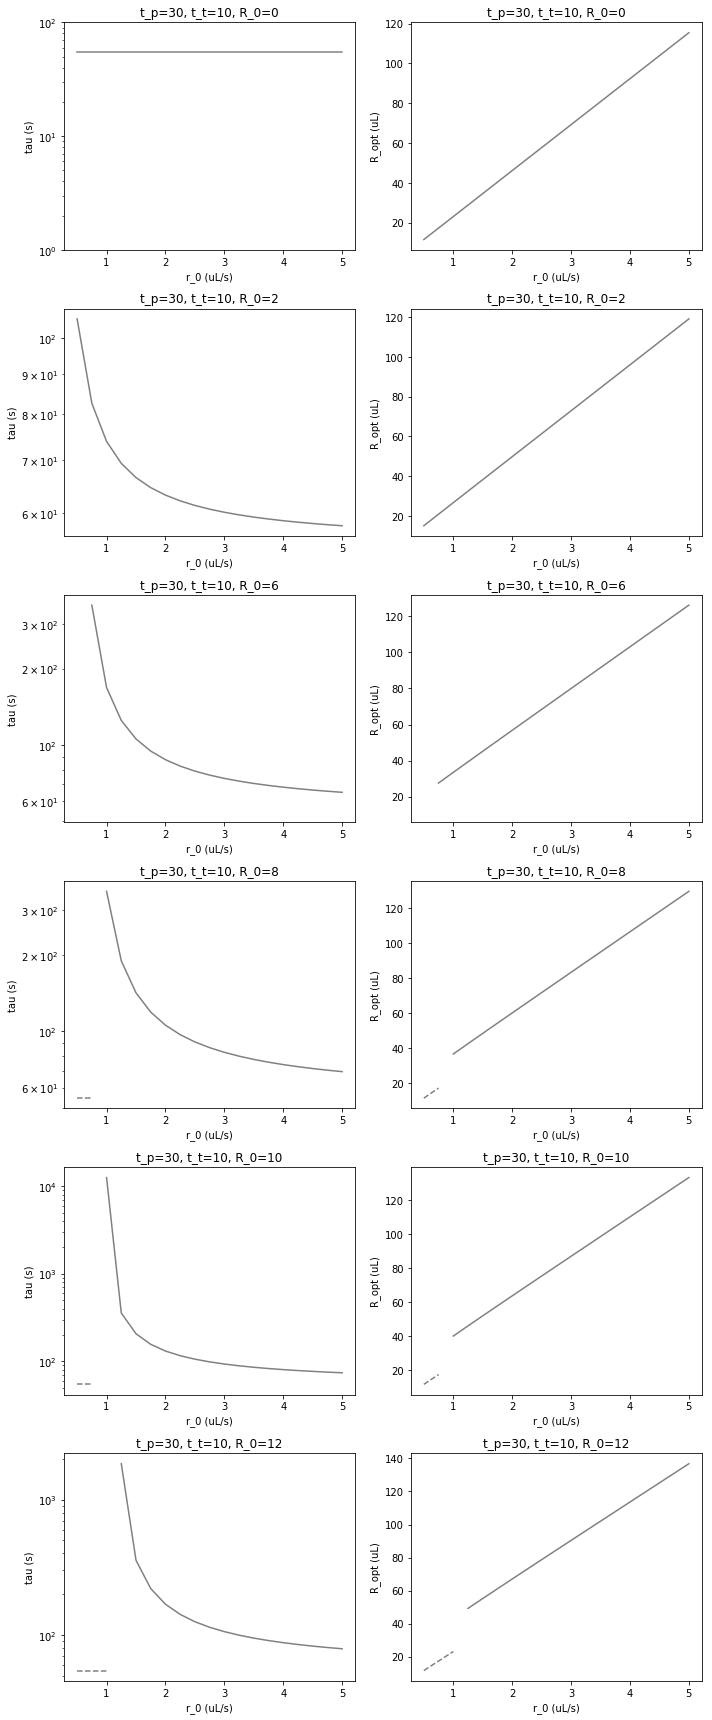

In [6]:
fig, ax = plt.subplots(tau.shape[0], 2, figsize=(10, 4*tau.shape[0]))

for i in range(tau.shape[0]):
    ax[i, 0].plot(r_0[is_solvable[i]], tau[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 0].plot(r_0[np.invert(is_solvable[i])], tau[i, np.invert(is_solvable[i])], linestyle='--', color='gray') 
    ax[i, 0].set_xlabel('r_0 (uL/s)')
    ax[i, 0].set_ylabel('tau (s)')
    ax[i, 0].set_title('t_p=%d, t_t=%d, R_0=%d' % (t_p, t_t, R_0[i]))
    ax[i, 0].set_yscale('log')
    
    ax[i, 1].plot(r_0[is_solvable[i]], R_opt[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 1].plot(r_0[np.invert(is_solvable[i])], R_opt[i, np.invert(is_solvable[i])], linestyle='--', color='gray')
    ax[i, 1].set_xlabel('r_0 (uL/s)')
    ax[i, 1].set_ylabel('R_opt (uL)')
    ax[i, 1].set_title('t_p=%d, t_t=%d, R_0=%d' % (t_p, t_t, R_0[i]))

ax[0, 0].set_ylim([1.0, 100.0])    
plt.tight_layout()

## Fit behavior to environment
Given environmental parameters, what is optimum behavior?

In [28]:
# Behavior parameters
t_t = 10

# Environment parameters
# Remember, R_0 / r_0 must be ≥ t_t, otherwise R_0 will default to zero!
R_0 = np.array([0.0])
r_0 = np.arange(50, 501, 50)/100
tau = np.arange(10, 60, 5)

# Solve for residence time, optimum cumulative reward
t_p = np.zeros([tau.shape[0], r_0.shape[0]])
R_opt = np.zeros([tau.shape[0], r_0.shape[0]])
is_solvable = np.ones([tau.shape[0], r_0.shape[0]], dtype=np.bool)
for i, tau_ in enumerate(tau):
    t_p[i, :], R_opt[i, :], is_solvable[i, :] = get_optimal_values(t_t=t_t, 
                                                                   R_0=R_0, 
                                                                   r_0=r_0,
                                                                   tau=tau_,
                                                                   return_solvable=True)

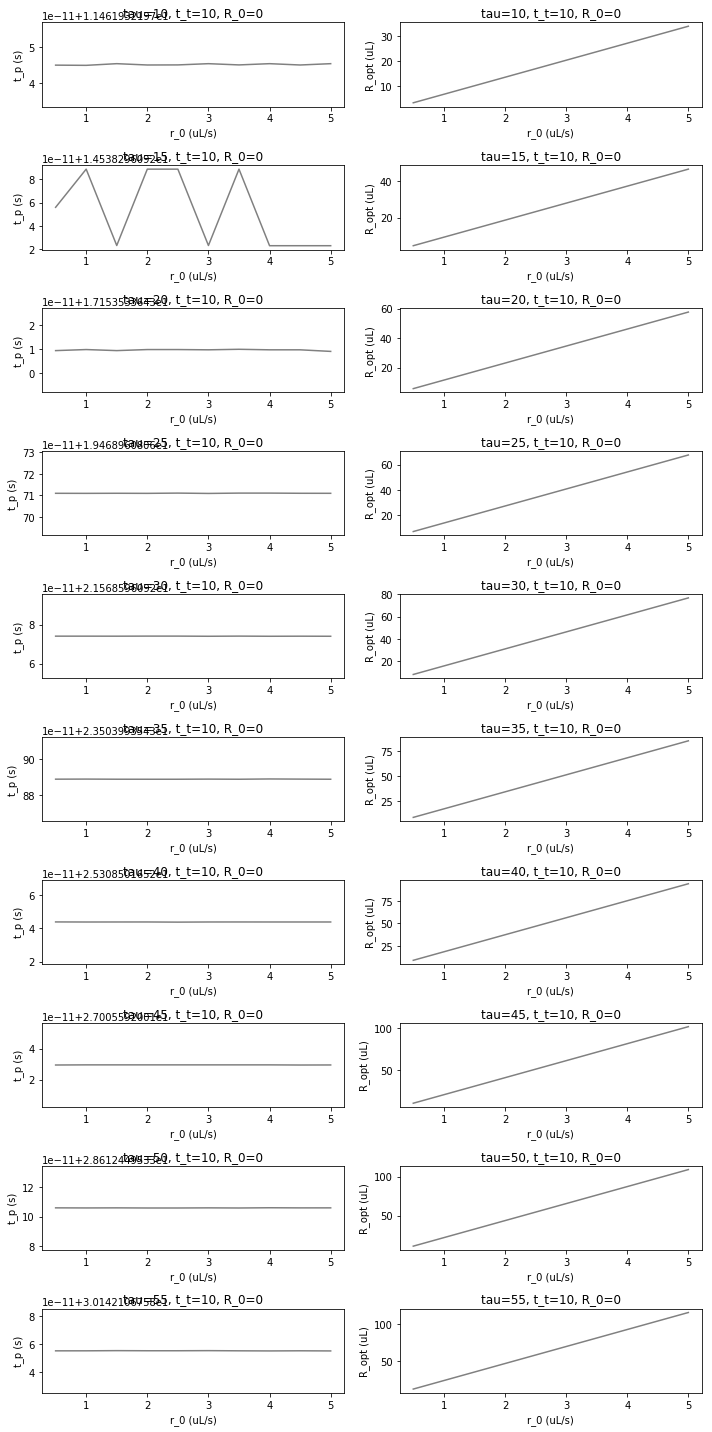

In [29]:
fig, ax = plt.subplots(t_p.shape[0], 2, figsize=(10, 20))

for i in range(t_p.shape[0]):
    ax[i, 0].plot(r_0[is_solvable[i]], t_p[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 0].plot(r_0[np.invert(is_solvable[i])], t_p[i, np.invert(is_solvable[i])], linestyle='--', color='gray') 
    ax[i, 0].set_xlabel('r_0 (uL/s)')
    ax[i, 0].set_ylabel('t_p (s)')
    ax[i, 0].set_title('tau=%d, t_t=%d, R_0=%d' % (tau[i], t_t, R_0))
    
    ax[i, 1].plot(r_0[is_solvable[i]], R_opt[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 1].plot(r_0[np.invert(is_solvable[i])], R_opt[i, np.invert(is_solvable[i])], linestyle='--', color='gray')
    ax[i, 1].set_xlabel('r_0 (uL/s)')
    ax[i, 1].set_ylabel('R_opt (uL)')
    ax[i, 1].set_title('tau=%d, t_t=%d, R_0=%d' % (tau[i], t_t, R_0))

#ax[0, 0].set_ylim([0.0, 100.0])    
plt.tight_layout()

In [30]:
# vary travel time and solve for residence time; see what values double residence time
# Behavior parameters
t_t = np.arange(10, 41, 5)

# Environment parameters
# Remember, R_0 / r_0 must be ≥ t_t, otherwise R_0 will default to zero!
R_0 = np.array([8.0])
r_0 = np.arange(50, 501, 50)/100
tau = np.array([60.0])

# Solve for residence time, optimum cumulative reward
t_p = np.zeros([t_t.shape[0], r_0.shape[0]])
R_opt = np.zeros([t_t.shape[0], r_0.shape[0]])
is_solvable = np.ones([t_t.shape[0], r_0.shape[0]], dtype=np.bool)
for i, t_t_ in enumerate(t_t):
    t_p[i, :], R_opt[i, :], is_solvable[i, :] = get_optimal_values(t_t=t_t_, 
                                                                   R_0=R_0, 
                                                                   r_0=r_0,
                                                                   tau=tau,
                                                                   return_solvable=True)

../python/helper.py:166: UserWarning: Some data points exceed minimum travel time. R_0 set to zero.
  warnings.warn('Some data points exceed minimum travel time. R_0 set to zero.')
../python/helper.py:166: UserWarning: Some data points exceed minimum travel time. R_0 set to zero.
  warnings.warn('Some data points exceed minimum travel time. R_0 set to zero.')


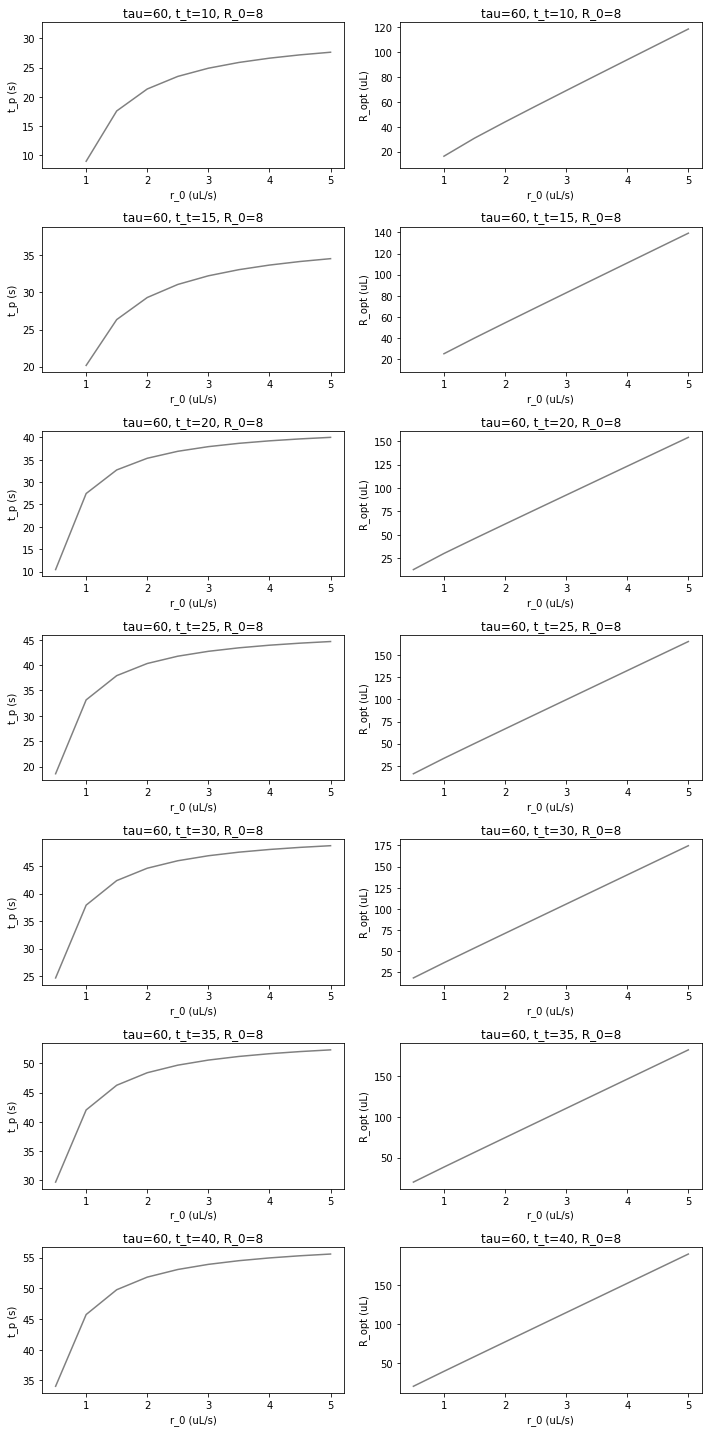

In [31]:
fig, ax = plt.subplots(t_p.shape[0], 2, figsize=(10, 20))

for i in range(t_p.shape[0]):
    ax[i, 0].plot(r_0[is_solvable[i]], t_p[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 0].plot(r_0[np.invert(is_solvable[i])], t_p[i, np.invert(is_solvable[i])], linestyle='--', color='gray') 
    ax[i, 0].set_xlabel('r_0 (uL/s)')
    ax[i, 0].set_ylabel('t_p (s)')
    ax[i, 0].set_title('tau=%d, t_t=%d, R_0=%d' % (tau, t_t[i], R_0))
    
    ax[i, 1].plot(r_0[is_solvable[i]], R_opt[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 1].plot(r_0[np.invert(is_solvable[i])], R_opt[i, np.invert(is_solvable[i])], linestyle='--', color='gray')
    ax[i, 1].set_xlabel('r_0 (uL/s)')
    ax[i, 1].set_ylabel('R_opt (uL)')
    ax[i, 1].set_title('tau=%d, t_t=%d, R_0=%d' % (tau, t_t[i], R_0))

#ax[0, 0].set_ylim([0.0, 100.0])    
plt.tight_layout()

### How does optimal harvest rate change with different environments?

In [34]:
# Behavior parameters
t_t = 5

# Environment parameters
# Remember, R_0 / r_0 must be ≥ t_t, otherwise R_0 will default to zero!
R_0 = np.array([0.0])
r_0 = np.arange(50, 501, 50)/100
tau = np.arange(10, 30, 1)

# Solve for residence time, optimum cumulative reward
t_p = np.zeros([r_0.shape[0], tau.shape[0]])
R_opt = np.zeros([r_0.shape[0], tau.shape[0]])
is_solvable = np.ones([r_0.shape[0], tau.shape[0]], dtype=np.bool)
for i, r_0_ in enumerate(r_0):
    t_p[i, :], R_opt[i, :], is_solvable[i, :] = get_optimal_values(t_t=t_t, 
                                                                   R_0=R_0, 
                                                                   r_0=r_0_,
                                                                   tau=tau,
                                                                   return_solvable=True)

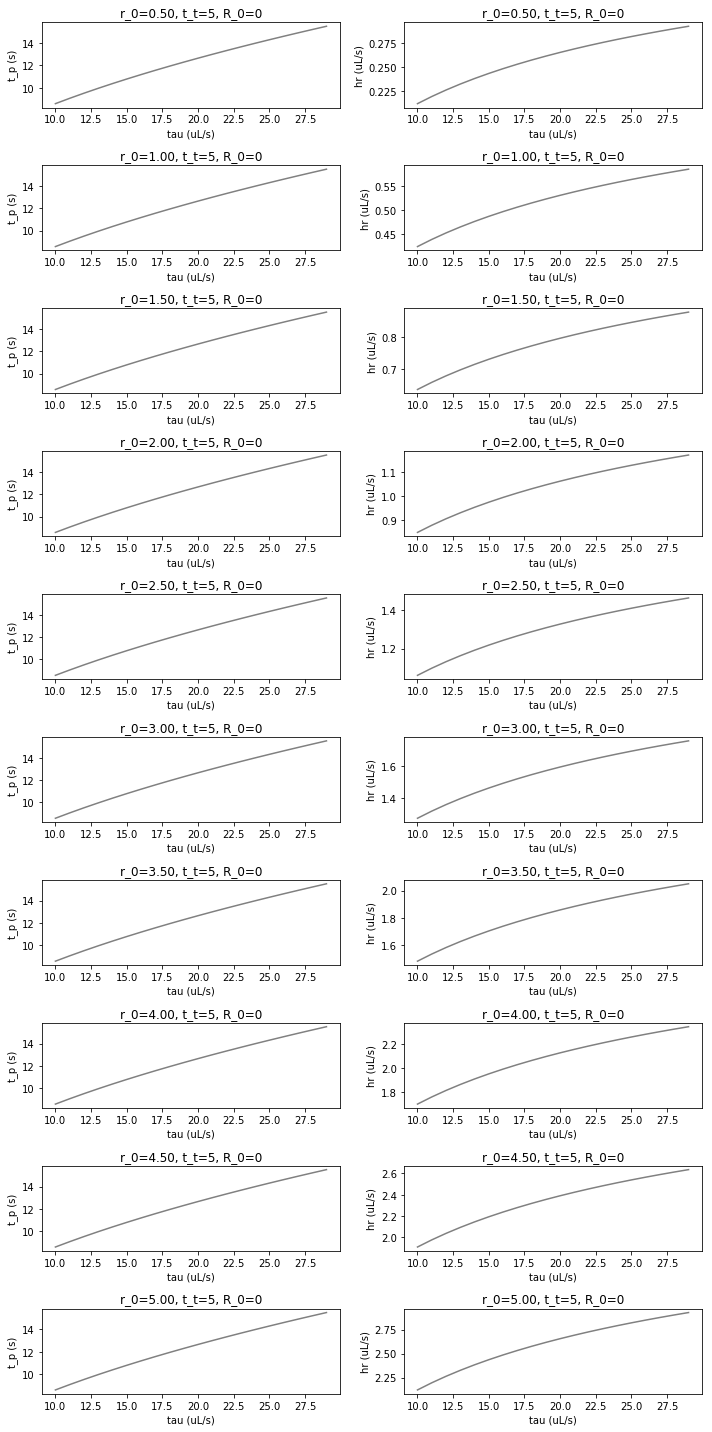

In [35]:
fig, ax = plt.subplots(r_0.shape[0], 2, figsize=(10, 20))

for i in range(r_0.shape[0]):
    ax[i, 0].plot(tau[is_solvable[i]], t_p[i, is_solvable[i]], linestyle='-', color='gray')
    ax[i, 0].plot(tau[np.invert(is_solvable[i])], t_p[i, np.invert(is_solvable[i])], linestyle='--', color='gray') 
    ax[i, 0].set_xlabel('tau (uL/s)')
    ax[i, 0].set_ylabel('t_p (s)')
    ax[i, 0].set_title('r_0=%.2f, t_t=%d, R_0=%d' % (r_0[i], t_t, R_0))
    
    ax[i, 1].plot(tau[is_solvable[i]], R_opt[i, is_solvable[i]]/(t_t + t_p[i, is_solvable[i]]), 
                  linestyle='-', color='gray')
    ax[i, 1].plot(tau[np.invert(is_solvable[i])], R_opt[i, np.invert(is_solvable[i])]/(t_t + t_p[i, np.invert(is_solvable[i])]), 
                  linestyle='--', color='gray') 
    ax[i, 1].set_xlabel('tau (uL/s)')
    ax[i, 1].set_ylabel('hr (uL/s)')
    ax[i, 1].set_title('r_0=%.2f, t_t=%d, R_0=%d' % (r_0[i], t_t, R_0))

plt.tight_layout()

In [27]:
t_t_ = 10
R_0_ = R_0[0]
r_0_ = 2.0
t_p_ = t_p[np.argwhere(t_t == t_t_)[0], np.argwhere(r_0 == r_0_)[0]] 
tau_ = tau[0]

print('t_p = %.2f, t_t = %.2f, R_0 = %.2f, r_0 = %.2f, tau = %.2f' % (t_p_, t_t_, R_0_, r_0_, tau_))

t_p = 21.35, t_t = 10.00, R_0 = 8.00, r_0 = 2.00, tau = 60.00


In [29]:
t_t_ = 25
R_0_ = R_0[0]
r_0_ = 2.0
t_p_ = t_p[np.argwhere(t_t == t_t_)[0], np.argwhere(r_0 == r_0_)[0]] 
tau_ = tau[0]

print('t_p = %.2f, t_t = %.2f, R_0 = %.2f, r_0 = %.2f, tau = %.2f' % (t_p_, t_t_, R_0_, r_0_, tau_))

t_p = 40.32, t_t = 25.00, R_0 = 8.00, r_0 = 2.00, tau = 60.00
